# Importing the required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from glob import glob
from tqdm import tqdm, tqdm_notebook
import random
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed

# Importing the data

In [2]:
print(os.listdir('../input/skin-cancer-mnist-ham10000/'))

['hmnist_28_28_L.csv', 'ham10000_images_part_2', 'hmnist_8_8_L.csv', 'ham10000_images_part_1', 'HAM10000_metadata.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'hmnist_8_8_RGB.csv', 'HAM10000_images_part_2']


In [3]:
path = '../input/skin-cancer-mnist-ham10000/'
images_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*', '*.jpg'))}

In [4]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
skin_df = pd.read_csv(os.path.join(path,'HAM10000_metadata.csv'))

In [6]:
skin_df['path'] = skin_df['image_id'].map(images_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [7]:
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


In [8]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((71,71))))


In [9]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,"[[[193, 156, 197], [191, 153, 194], [193, 147,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,"[[[20, 12, 25], [22, 16, 26], [32, 19, 39], [5..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,"[[[185, 129, 138], [195, 134, 150], [199, 146,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,"[[[23, 10, 17], [33, 17, 28], [60, 32, 44], [8..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,"[[[139, 94, 117], [154, 110, 135], [173, 131, ..."


In [10]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(71, 71, 3)    10015
Name: image, dtype: int64

Taking X as image and y as cell_type_idx

In [11]:
X = skin_df['image']
y = skin_df['cell_type_idx']

In [12]:
X = X.values
X = X/255.0
X.shape

(10015,)

In [13]:
lst = []
for _ in X:
    lst.append(_)
X = np.array(lst)
print(X.shape)

(10015, 71, 71, 3)


# Splitting the data

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.10,random_state=28)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.10,random_state=28)

## One hot encoding of the y labels

In [15]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 7)
y_val = to_categorical(y_val , num_classes=7)

Using TensorFlow backend.


In [16]:
batch_size = 256
train_input_shape = (71, 71, 3)
n_classes = 7

In [17]:
from tensorflow.keras.layers import Input

# Building a model

In [18]:
# Load pre-trained model
base_model = Xception(include_top = False , input_shape = train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

83689472/83683744 [==============================] - 1s 0us/step


In [19]:
# Add layers at the end
model = base_model.output
model = Flatten()(model)


model = Dense(128)(model)
model = Activation('relu')(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)


output = Dense(n_classes, activation='softmax')(model)

model = Model(inputs=base_model.input, outputs=output)

In [20]:
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [21]:
n_epoch = 30

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

# Training the Model

In [22]:
history = model.fit(x_train,
                    y_train,
                    epochs=n_epoch,
                    callbacks=[reduce_lr,early_stop],
                    validation_data=(x_val,y_val)
                   )

Train on 8111 samples, validate on 902 samples
Epoch 1/30
8111/8111 [==============================] - 27s 3ms/sample - loss: 0.8422 - accuracy: 0.7032 - val_loss: 0.8353 - val_accuracy: 0.7572
Epoch 2/30
8111/8111 [==============================] - 17s 2ms/sample - loss: 0.6362 - accuracy: 0.7744 - val_loss: 0.6974 - val_accuracy: 0.7661
Epoch 3/30
8111/8111 [==============================] - 17s 2ms/sample - loss: 0.5305 - accuracy: 0.8140 - val_loss: 0.8712 - val_accuracy: 0.7605
Epoch 4/30
8111/8111 [==============================] - 17s 2ms/sample - loss: 0.4389 - accuracy: 0.8465 - val_loss: 1.0728 - val_accuracy: 0.7206
Epoch 5/30
8111/8111 [==============================] - 16s 2ms/sample - loss: 0.3382 - accuracy: 0.8819 - val_loss: 0.6978 - val_accuracy: 0.7871
Epoch 6/30
8111/8111 [==============================] - 17s 2ms/sample - loss: 0.2612 - accuracy: 0.9138 - val_loss: 0.7099 - val_accuracy: 0.7982
Epoch 7/30
8096/8111 [============================>.] - ETA: 0s - loss:

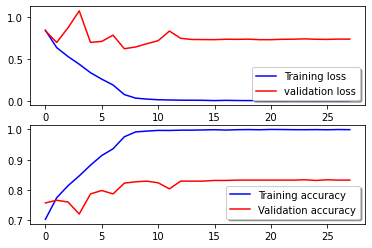

In [23]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 71, 71, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 35, 35, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 35, 35, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 35, 35, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

# Model to feature Extractor


In [28]:
model2 = Model(model.input, model.layers[-3].output)
# model2.summary()

In [29]:
predictions = model2.predict(X)

In [30]:
predictions[0]

array([-1.1373663 , -0.5570788 ,  0.05991513,  0.27708387,  0.4871875 ,
       -0.8676044 ,  2.3046772 ,  0.49547243, -1.242319  , -2.0342667 ,
        0.39091596, -0.33172628,  1.0433778 ,  0.39036518, -1.0031228 ,
       -1.0955603 ,  0.9796598 , -1.6976211 ,  1.5036252 , -0.6025878 ,
        0.4138679 ,  2.3372598 , -1.3197528 ,  0.13303572,  2.7441769 ,
        1.943125  ,  1.5209076 , -1.2694111 ,  1.0786083 , -1.2938105 ,
       -1.3059233 , -0.27928925, -0.83896625, -1.8176224 ,  0.6235406 ,
        1.3279164 ,  2.303233  , -0.78797966, -1.5974529 , -1.5830044 ,
       -0.8646048 , -1.6695378 , -0.5948925 , -1.2610155 , -1.7609155 ,
        2.3804755 , -0.6012624 ,  0.85327995, -1.9343239 , -0.8839081 ,
       -1.6028292 , -0.96766233, -1.3272216 ,  2.3080432 , -1.5008806 ,
       -1.0918672 , -1.7371002 ,  1.1294386 , -1.067877  ,  1.4497231 ,
       -1.3824176 ,  0.3694706 ,  1.7161077 ,  1.9230297 , -2.0196812 ,
        0.8426941 , -0.42371017, -0.7324901 ,  1.513058  , -1.05

In [31]:
len(predictions[0])

128

from feature extractor we will get the output as np array of length 52

In [32]:
data_df = skin_df

In [33]:
complete_data = pd.concat([data_df, pd.DataFrame(predictions)], axis=1)

In [34]:
complete_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,...,118,119,120,121,122,123,124,125,126,127
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,...,-1.251251,0.390182,-1.821648,1.595066,-0.985105,1.276693,-1.315942,-1.947903,0.798475,2.189595
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,...,-1.195403,0.547725,-2.221224,1.198478,-1.466083,1.880450,-0.778410,-2.634483,-0.008423,2.660560
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,...,-1.323530,-0.522528,-1.378800,-1.099846,-0.009460,-0.144234,1.380359,-2.096637,-3.015361,1.125205
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,...,-0.731543,0.063376,-0.990273,1.503191,-0.554992,0.686756,-0.840952,-1.074797,0.852784,0.948702
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,...,-0.013775,0.556896,-1.307156,0.958934,-0.824228,1.554494,-0.282883,-1.673673,1.156181,1.561657


# Saving the model

Saving both the complete model and the feature extractor

In [35]:
### saving a model!!!!!

model_json = model2.to_json()
with open("model_v2.json", "w") as json_file:
    json_file.write(model_json)

In [36]:
### saving a model!!!!!

completemodel_json = model.to_json()
with open("completemodel1.json", "w") as json_file:
    json_file.write(completemodel_json)

In [37]:
model2.save_weights("model_v2_weights.h5")
print("Saved model to disk")

Saved model to disk


In [38]:
model.save_weights("completeweights.h5")
print("Saved model to disk")

Saved model to disk


# Preparing a new Dataset

In this new Dataset the image is changed to the 52 new features

In [39]:
complete_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,...,118,119,120,121,122,123,124,125,126,127
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,...,-1.251251,0.390182,-1.821648,1.595066,-0.985105,1.276693,-1.315942,-1.947903,0.798475,2.189595
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,...,-1.195403,0.547725,-2.221224,1.198478,-1.466083,1.880450,-0.778410,-2.634483,-0.008423,2.660560
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,...,-1.323530,-0.522528,-1.378800,-1.099846,-0.009460,-0.144234,1.380359,-2.096637,-3.015361,1.125205
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,...,-0.731543,0.063376,-0.990273,1.503191,-0.554992,0.686756,-0.840952,-1.074797,0.852784,0.948702
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,...,-0.013775,0.556896,-1.307156,0.958934,-0.824228,1.554494,-0.282883,-1.673673,1.156181,1.561657


In [40]:
complete_data.columns

Index([    'lesion_id',      'image_id',            'dx',       'dx_type',
                 'age',           'sex',  'localization',          'path',
           'cell_type', 'cell_type_idx',
       ...
                   118,             119,             120,             121,
                   122,             123,             124,             125,
                   126,             127],
      dtype='object', length=139)

# One hot-encoding 

In [41]:
dxtype_df=pd.get_dummies(complete_data['dx_type'],drop_first=False)
complete_data=pd.concat([dxtype_df,complete_data],axis=1)
# complete_data.drop(['dx_type'],axis=1,inplace=True)
complete_data.head()

,confocal,consensus,follow_up,histo,lesion_id,image_id,dx,dx_type,age,sex,...,118,119,120,121,122,123,124,125,126,127
0,0,0,0,1,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,...,-1.251251,0.390182,-1.821648,1.595066,-0.985105,1.276693,-1.315942,-1.947903,0.798475,2.189595
1,0,0,0,1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,...,-1.195403,0.547725,-2.221224,1.198478,-1.466083,1.880450,-0.778410,-2.634483,-0.008423,2.660560
2,0,0,0,1,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,...,-1.323530,-0.522528,-1.378800,-1.099846,-0.009460,-0.144234,1.380359,-2.096637,-3.015361,1.125205
3,0,0,0,1,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,...,-0.731543,0.063376,-0.990273,1.503191,-0.554992,0.686756,-0.840952,-1.074797,0.852784,0.948702
4,0,0,0,1,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,...,-0.013775,0.556896,-1.307156,0.958934,-0.824228,1.554494,-0.282883,-1.673673,1.156181,1.561657


In [42]:
localization_df=pd.get_dummies(complete_data['localization'],drop_first=False)
complete_data=pd.concat([localization_df,complete_data],axis=1)
# complete_data.drop(['dx_type'],axis=1,inplace=True)
complete_data.head()

,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,...,118,119,120,121,122,123,124,125,126,127
0,0,0,0,0,0,0,0,0,0,0,...,-1.251251,0.390182,-1.821648,1.595066,-0.985105,1.276693,-1.315942,-1.947903,0.798475,2.189595
1,0,0,0,0,0,0,0,0,0,0,...,-1.195403,0.547725,-2.221224,1.198478,-1.466083,1.880450,-0.778410,-2.634483,-0.008423,2.660560
2,0,0,0,0,0,0,0,0,0,0,...,-1.323530,-0.522528,-1.378800,-1.099846,-0.009460,-0.144234,1.380359,-2.096637,-3.015361,1.125205
3,0,0,0,0,0,0,0,0,0,0,...,-0.731543,0.063376,-0.990273,1.503191,-0.554992,0.686756,-0.840952,-1.074797,0.852784,0.948702
4,0,0,0,0,1,0,0,0,0,0,...,-0.013775,0.556896,-1.307156,0.958934,-0.824228,1.554494,-0.282883,-1.673673,1.156181,1.561657


In [43]:
sex_df=pd.get_dummies(complete_data['sex'],drop_first=False)
sex_df.drop(['unknown'],axis=1,inplace=True)
complete_data=pd.concat([sex_df,complete_data],axis=1)
# complete_data.drop(['dx_type'],axis=1,inplace=True)
complete_data.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,...,118,119,120,121,122,123,124,125,126,127
0,0,1,0,0,0,0,0,0,0,0,...,-1.251251,0.390182,-1.821648,1.595066,-0.985105,1.276693,-1.315942,-1.947903,0.798475,2.189595
1,0,1,0,0,0,0,0,0,0,0,...,-1.195403,0.547725,-2.221224,1.198478,-1.466083,1.880450,-0.778410,-2.634483,-0.008423,2.660560
2,0,1,0,0,0,0,0,0,0,0,...,-1.323530,-0.522528,-1.378800,-1.099846,-0.009460,-0.144234,1.380359,-2.096637,-3.015361,1.125205
3,0,1,0,0,0,0,0,0,0,0,...,-0.731543,0.063376,-0.990273,1.503191,-0.554992,0.686756,-0.840952,-1.074797,0.852784,0.948702
4,0,1,0,0,0,0,1,0,0,0,...,-0.013775,0.556896,-1.307156,0.958934,-0.824228,1.554494,-0.282883,-1.673673,1.156181,1.561657


In [44]:
complete_data.columns

Index([ 'female',    'male', 'abdomen',   'acral',    'back',   'chest',
           'ear',    'face',    'foot', 'genital',
       ...
             118,       119,       120,       121,       122,       123,
             124,       125,       126,       127],
      dtype='object', length=160)

In [45]:
X_labels = complete_data.drop(['lesion_id','image_id','dx_type','dx','path','cell_type','cell_type_idx','sex','path','localization','image'],axis=1,inplace=False)
y_label = complete_data['cell_type_idx']

In [46]:
X_labels.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,...,118,119,120,121,122,123,124,125,126,127
0,0,1,0,0,0,0,0,0,0,0,...,-1.251251,0.390182,-1.821648,1.595066,-0.985105,1.276693,-1.315942,-1.947903,0.798475,2.189595
1,0,1,0,0,0,0,0,0,0,0,...,-1.195403,0.547725,-2.221224,1.198478,-1.466083,1.880450,-0.778410,-2.634483,-0.008423,2.660560
2,0,1,0,0,0,0,0,0,0,0,...,-1.323530,-0.522528,-1.378800,-1.099846,-0.009460,-0.144234,1.380359,-2.096637,-3.015361,1.125205
3,0,1,0,0,0,0,0,0,0,0,...,-0.731543,0.063376,-0.990273,1.503191,-0.554992,0.686756,-0.840952,-1.074797,0.852784,0.948702
4,0,1,0,0,0,0,1,0,0,0,...,-0.013775,0.556896,-1.307156,0.958934,-0.824228,1.554494,-0.282883,-1.673673,1.156181,1.561657


# Saving a new Dataset

In [47]:
complete_data.to_csv('skin_data_v2.csv')

In [48]:
preds = model.predict(x_test)

In [49]:
lst = []
for a in preds:
    lst.append(np.argmax(a))

In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# CNN Model evaluation 

In [51]:
confusion_matrix(lst,y_test)

array([[ 24,   3,   4,   2,   4,   3,   0],
       [  9,  37,   2,   1,   4,   3,   0],
       [  4,   6,  71,   0,   9,  20,   0],
       [  0,   0,   0,   9,   0,   0,   1],
       [  0,   3,  23,   2, 614,  29,   2],
       [  5,   0,   7,   1,  23,  57,   2],
       [  0,   0,   0,   0,   0,   0,  18]])

In [52]:
accuracy_score(lst,y_test)

0.8283433133732535

In [53]:
print(classification_report(y_test,lst))

              precision    recall  f1-score   support

           0       0.60      0.57      0.59        42
           1       0.66      0.76      0.70        49
           2       0.65      0.66      0.65       107
           3       0.90      0.60      0.72        15
           4       0.91      0.94      0.93       654
           5       0.60      0.51      0.55       112
           6       1.00      0.78      0.88        23

    accuracy                           0.83      1002
   macro avg       0.76      0.69      0.72      1002
weighted avg       0.83      0.83      0.83      1002



In [54]:
skin_df = pd.read_csv('skin_data_v2.csv')

In [55]:
skin_df.drop(['Unnamed: 0'],axis=1,inplace=True)
skin_df.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,...,118,119,120,121,122,123,124,125,126,127
0,0,1,0,0,0,0,0,0,0,0,...,-1.251251,0.390182,-1.821648,1.595066,-0.985105,1.276693,-1.315942,-1.947903,0.798475,2.189595
1,0,1,0,0,0,0,0,0,0,0,...,-1.195403,0.547725,-2.221224,1.198479,-1.466083,1.880450,-0.778410,-2.634483,-0.008423,2.660560
2,0,1,0,0,0,0,0,0,0,0,...,-1.323530,-0.522528,-1.378800,-1.099846,-0.009460,-0.144234,1.380359,-2.096637,-3.015361,1.125205
3,0,1,0,0,0,0,0,0,0,0,...,-0.731543,0.063376,-0.990273,1.503191,-0.554992,0.686756,-0.840952,-1.074797,0.852784,0.948702
4,0,1,0,0,0,0,1,0,0,0,...,-0.013775,0.556896,-1.307156,0.958934,-0.824228,1.554494,-0.282883,-1.673673,1.156181,1.561657


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing a new dataset

In [57]:
skin_df.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,...,118,119,120,121,122,123,124,125,126,127
0,0,1,0,0,0,0,0,0,0,0,...,-1.251251,0.390182,-1.821648,1.595066,-0.985105,1.276693,-1.315942,-1.947903,0.798475,2.189595
1,0,1,0,0,0,0,0,0,0,0,...,-1.195403,0.547725,-2.221224,1.198479,-1.466083,1.880450,-0.778410,-2.634483,-0.008423,2.660560
2,0,1,0,0,0,0,0,0,0,0,...,-1.323530,-0.522528,-1.378800,-1.099846,-0.009460,-0.144234,1.380359,-2.096637,-3.015361,1.125205
3,0,1,0,0,0,0,0,0,0,0,...,-0.731543,0.063376,-0.990273,1.503191,-0.554992,0.686756,-0.840952,-1.074797,0.852784,0.948702
4,0,1,0,0,0,0,1,0,0,0,...,-0.013775,0.556896,-1.307156,0.958934,-0.824228,1.554494,-0.282883,-1.673673,1.156181,1.561657


In [58]:
X_labels = skin_df.drop(['lesion_id','image_id','dx','dx_type','sex','localization','path','cell_type','cell_type_idx','image'],axis=1,inplace=False)
y_label = skin_df['cell_type_idx']

In [66]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_labels,y_label,test_size=0.10,random_state=28)
# X_train,x_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.20, random_state=28)

In [67]:
import xgboost as xgb

In [68]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=-1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=1855, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=0)

In [69]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=1855, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=1855, silent=None,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=0)

# CNN + Xgboost evaluation

In [70]:
y_pred = clf.predict(X_test)

In [71]:
confusion_matrix(y_test,y_pred)

array([[ 22,   9,   7,   0,   0,   4,   0],
       [  3,  35,   8,   0,   2,   1,   0],
       [  4,   0,  69,   0,  26,   8,   0],
       [  2,   0,   1,  10,   1,   1,   0],
       [  5,   3,  10,   0, 617,  19,   0],
       [  3,   3,  13,   0,  29,  64,   0],
       [  0,   0,   0,   1,   2,   1,  19]])

In [72]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.56      0.52      0.54        42
           1       0.70      0.71      0.71        49
           2       0.64      0.64      0.64       107
           3       0.91      0.67      0.77        15
           4       0.91      0.94      0.93       654
           5       0.65      0.57      0.61       112
           6       1.00      0.83      0.90        23

    accuracy                           0.83      1002
   macro avg       0.77      0.70      0.73      1002
weighted avg       0.83      0.83      0.83      1002

